## Original Source: https://www.datacamp.com/tutorial/sam2-fine-tuning

In [1]:
import os
import pandas as pd
import cv2
import torch
import torch.nn.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


C:\Users\dockn\SAM-code\segment-anything-2\sam2\modeling\sam\transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [46]:
train_sets = [
    r"C:\Users\dockn\Downloads\WaterDataset\train_images\JPEGImages\river_segs", 
    r"C:\Users\dockn\Downloads\WaterDataset\train_images\JPEGImages\flooding_pixabay", 
    r"C:\Users\dockn\Downloads\WaterDataset\train_images\JPEGImages\ADE20K_water"
]

mask_sets = [
    r"C:\Users\dockn\Downloads\WaterDataset\train_images\Annotations\river_segs",
    r"C:\Users\dockn\Downloads\WaterDataset\train_images\Annotations\flooding_pixabay",
    r"C:\Users\dockn\Downloads\WaterDataset\train_images\Annotations\ADE20K_water",
]

train_data = []
for images_dir, masks_dir in zip(train_sets, mask_sets):
    for img, msk in zip(os.listdir(images_dir), os.listdir(masks_dir)):
        train_data.append({
            "image": os.path.join(images_dir, img),
            "annotation": os.path.join(masks_dir, msk)
        })

기존 데이터셋

In [2]:
# Path to the water segmentation dataset folder
data_dir = r"C:\Users\dockn\SAM-code\EGU2024_total_river\train"
images_dir = os.path.join(data_dir, r"JPEGImages\dataset")
masks_dir = os.path.join(data_dir, r"Annotations\dataset")

train_data = []
for img, msk in zip(os.listdir(images_dir), os.listdir(masks_dir)):
   train_data.append({
       "image": os.path.join(images_dir, img),
       "annotation": os.path.join(masks_dir, msk)
   })

val_imgs = r"C:\Users\dockn\SAM-code\EGU2024_total_river\val\JPEGImages\dataset"
val_msks = r"C:\Users\dockn\SAM-code\EGU2024_total_river\val\Annotations\dataset"
val_data = []
for img, msk in zip(os.listdir(val_imgs), os.listdir(val_msks)):
   val_data.append({
      "image": os.path.join(val_imgs, img),
      "annotation": os.path.join(val_msks, msk)
   })

# Prepare the testing data list (if needed for inference or evaluation later)
test_dir = r"C:\Users\dockn\SAM-code\EGU2024_total_river\test"
t_img = os.path.join(test_dir, "JPEGImages", "dataset")
t_msk = os.path.join(test_dir, "Annotations", "dataset")

test_data = []
for img, msk in zip(os.listdir(t_img), os.listdir(t_msk)):
   # Append image and corresponding mask paths
   test_data.append({
       "image": os.path.join(t_img, img),
       "annotation": os.path.join(t_msk, msk)
   })


In [3]:
def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data[np.random.randint(len(data))]

    # Get full paths
    Img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

    if Img is None or ann_map is None:
        print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
        return None, None, None, 0

    # Resize image and mask
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []

    # Get binary masks and combine them into a single mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
        binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

    # Erode the combined binary mask to avoid boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # Get all coordinates inside the eroded mask and choose a random point
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
        for _ in inds:  # Select as many points as there are unique labels
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([yx[1], yx[0]])

    points = np.array(points)
    ### Continuation of read_batch() ###

    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)

    # Return the image, binarized mask, points, and number of masks
    return Img, binary_mask, points, len(inds)


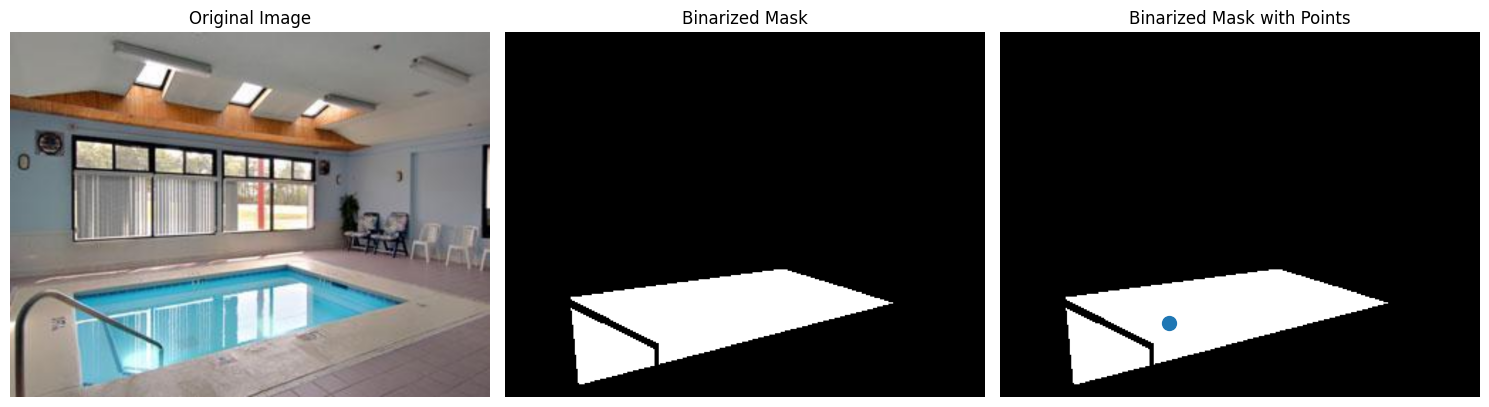

In [48]:
# Visualize the data
Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

In [49]:
sam2_checkpoint = "../checkpoints/sam2_hiera_small.pt"  # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2_hiera_s.yaml" # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)


In [50]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 3000 # @param 

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "Vflood"


In [51]:
import wandb

wandb.init(
    project="sam2",
    config={
        "epochs": NO_OF_STEPS,
        "dataset": "EGU2024_total_river",
        "learning_rate": optimizer.state_dict()['param_groups'][0]["lr"]
    }
)

IoU,▆▁▃█▆▄▇▇▁▆
Total loss,▅▄▃▁▃▃▁▁▂█
score loss,▅██▁▃▅▁▃█▆
seg loss,▅▄▃▁▃▃▁▁▁█
IoU,0.80184
Total loss,0.46813
score loss,0.11613
seg loss,0.46232


In [52]:
# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) # 500 , 250, gamma = 0.1
accumulation_steps = 4  # Number of steps to accumulate gradients before updating

for step in range(1, NO_OF_STEPS + 1):
   with torch.cuda.amp.autocast():
   # with torch.autocast("cuda"):

       image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)
       if image is None or mask is None or num_masks == 0:
           continue

       input_label = np.ones((num_masks, 1))
       if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
           continue

       if input_point.size == 0 or input_label.size == 0:
           continue

       predictor.set_image(image)
       mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
       if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
           continue

       sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
           points=(unnorm_coords, labels), boxes=None, masks=None,
       )

       batched_mode = unnorm_coords.shape[0] > 1
       high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
       low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
           image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
           image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
           sparse_prompt_embeddings=sparse_embeddings,
           dense_prompt_embeddings=dense_embeddings,
           multimask_output=True,
           repeat_image=batched_mode,
           high_res_features=high_res_features,
       )
       prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

       gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
       prd_mask = torch.sigmoid(prd_masks[:, 0])
       seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean() # focal

       inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
       iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
       score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
       loss = seg_loss + score_loss * 0.05

       wandb.log({
                "IoU": iou,
                "seg loss": seg_loss,
                "score loss": score_loss,
                "Total loss": loss
            },
            step=step
        )

       # Apply gradient accumulation
       loss = loss / accumulation_steps
       scaler.scale(loss).backward()

       # Clip gradients
       torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

       if step % accumulation_steps == 0:
           scaler.step(optimizer)
           scaler.update()
           predictor.model.zero_grad()

       # Update scheduler
       scheduler.step()

       if step % 500 == 0:
           FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
           torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

       if step == 1:
           mean_iou = 0

       mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

       if step % 100 == 0:
           print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)


Step 100:	 Accuracy (IoU) =  0.3863333465284662
Step 200:	 Accuracy (IoU) =  0.5572357030697195
Step 300:	 Accuracy (IoU) =  0.6837207322485022
Step 400:	 Accuracy (IoU) =  0.7234145182803579
Step 500:	 Accuracy (IoU) =  0.6976488203855998
Step 600:	 Accuracy (IoU) =  0.7319107945101633
Step 700:	 Accuracy (IoU) =  0.7428268798997928
Step 800:	 Accuracy (IoU) =  0.7452767241244923
Step 900:	 Accuracy (IoU) =  0.7225410361302045
Step 1000:	 Accuracy (IoU) =  0.7431227996079885
Step 1100:	 Accuracy (IoU) =  0.7533657621367675
Step 1200:	 Accuracy (IoU) =  0.7267198035833498
Step 1300:	 Accuracy (IoU) =  0.7493501820688847
Step 1400:	 Accuracy (IoU) =  0.7655396731374152
Step 1500:	 Accuracy (IoU) =  0.7729841225072493
Step 1600:	 Accuracy (IoU) =  0.7401047182401365
Step 1700:	 Accuracy (IoU) =  0.7548421115246975
Step 1800:	 Accuracy (IoU) =  0.7438795281527829
Step 1900:	 Accuracy (IoU) =  0.7578528298002868
Step 2000:	 Accuracy (IoU) =  0.7370836420420999
Step 2100:	 Accuracy (IoU) = 

In [53]:
wandb.finish()

IoU,▇█▁████▇▃▇▇█▇▇▂█▇██▃█▃█▇▇████▇▇▇▃▇▆▃▆▅█▆
Total loss,▁▁▇▃▃▂▁▄▁▃▁▄▁▄▁▂▁▂▁▁▁▁▁█▁▁▁▁▁▂▄▁▁▃▂▂▂▁▂▄
score loss,▂▁▁▂▁▃▄▁▂▁▃▁▁▁▁▁▁▄▁▁▁▂▁▁▃▁█▂▁▁▂▁▁▁▁▂▅▂▁█
seg loss,▁▁▁▁▁▁▁▁▁▂▁▁▁▁█▁▁▁▁▁▁▂▃▁▁▁▁▁▁▂▂▂▁▁▃▁▁▁▁▁
IoU,0.96447
Total loss,0.03025
score loss,0.02013
seg loss,0.02924


In [54]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

In [55]:
import random
random.seed(42)

In [56]:
def calculate_iou(segmentation_mask1, segmentation_mask2):
    if segmentation_mask1.shape != segmentation_mask2.shape:
        raise ValueError("두 세그멘테이션 마스크는 동일한 크기여야 합니다.")

    intersection = np.logical_and(segmentation_mask1, segmentation_mask2)
    intersection_area = np.sum(intersection)

    union = np.logical_or(segmentation_mask1, segmentation_mask2)
    union_area = np.sum(union)

    iou = intersection_area / union_area if union_area != 0 else 0.0

    return iou

실험 결과 Img 번호: 2, 25, 29

In [57]:
from PIL import Image

In [58]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

IoU: 0.9860
IoU: 0.9862
IoU: 0.9864


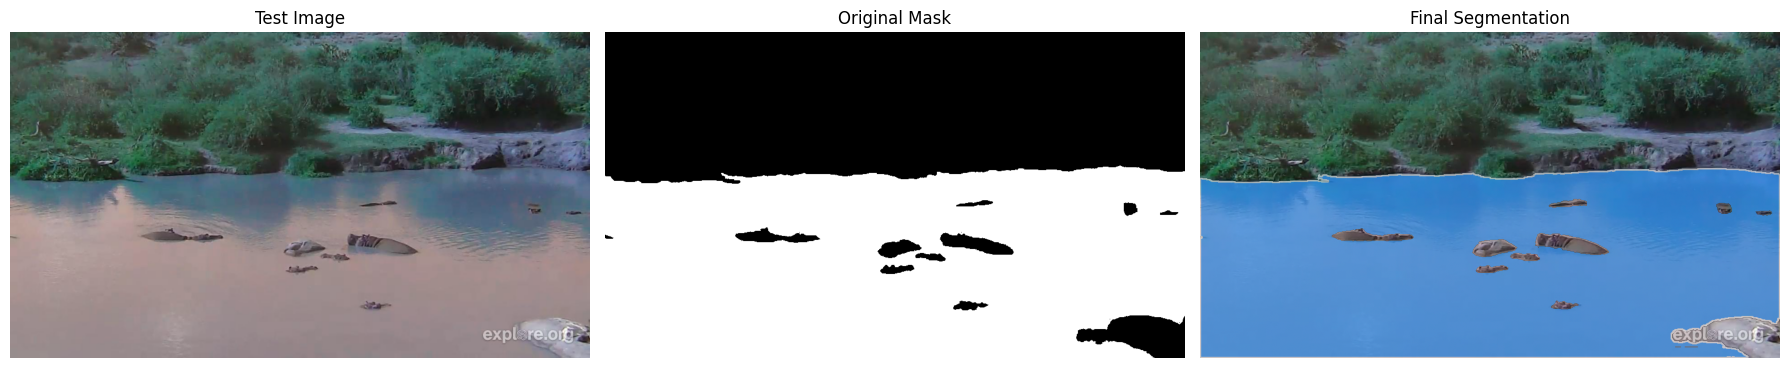

In [103]:
# Randomly select a test image from the test_data
selected_entry = random.choice(test_data)

# selected_entry = test_data[29]
image_path = selected_entry['image']
mask_path = selected_entry['annotation']

# Load the selected image and mask
image, gt = read_image(image_path, mask_path)
# Generate random points for the input
num_samples = 3  # Number of points per segment to sample
input_points = get_points(gt, num_samples)

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = r"vflood_tuning\Vflood_2500.torch"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
    mask = sorted_masks[i]

    mask_bool = mask.astype(bool)
    mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
    seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
    occupancy_mask[mask_bool] = True  # Update occupancy_mask

    # Visualization: Show the original image, mask, and final segmentation side by side

    iou = calculate_iou(gt, seg_map)
    print(f"IoU: {iou:.4f}")
    
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(gt, cmap='gray')
plt.axis('off')

seg_map = seg_map.astype(bool)

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(image)
show_mask(seg_map, plt.gca())
plt.axis('off')

plt.tight_layout()
plt.show()

결과

정적 0.956

동적 0.961

혼합 0.951

prompt(점 표시) 수에 대한 성능 차이 추가 예정

In [107]:
imgs = r"C:\Users\dockn\Downloads\WaterDataset\test_videos\boston_harbor_20200617_20200619"
for idx, img in enumerate(os.listdir(imgs)):
    np_img = cv2.imread(os.path.join(imgs, img))
    with torch.no_grad():
        predictor.set_image(np_img)
        masks, scores, logits = predictor.predict(
            point_coords=[[400,200]],
            point_labels=np.array([1])
        )
    plt.imshow(np_img)
    show_mask(masks[0], plt.gca())
    plt.axis(False)
    plt.tight_layout()
    plt.savefig(f"inference_vflood/{idx:05}.jpg")
    plt.close()

(-0.5, 1023.5, 767.5, -0.5)

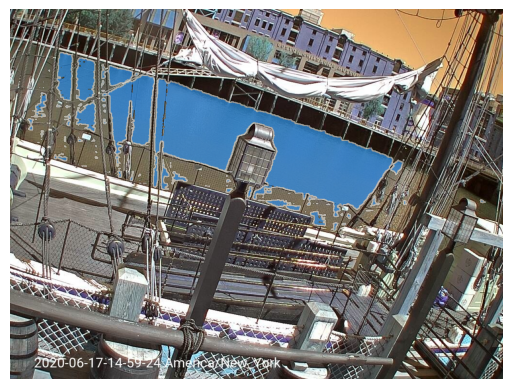

In [98]:
plt.close()